# First, mount the drive to get access to dataset

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Load the dataset from drive

In [2]:
import os
import pandas as pd

# Specify the path to dataset and the file name
DATASET_DIR = os.path.join(os.getcwd(), r'drive/MyDrive/NLP Final Project/datasets/sentiment140_kaggle')
FILE = os.path.join(DATASET_DIR, r'Sentiment140.annotated.resampled.100000.csv')

# Open the csv file as a pandas DataFrame with specified columns
tweets_df = pd.read_csv(FILE, sep=',', encoding='utf-8')
tweets_df

,target,tweet,label
0,0,@mimsay We'll miss you. Congrats lil lady.,negative
1,0,Feeling sorry for myself today cos of my drunk...,negative
2,0,My computer won't let me online. On laptop n...,negative
3,0,New Post and lots of sulking http://tinyurl...,negative
4,0,@purplepleather AWW,negative
...,...,...,...
999995,4,@babygirlparis Ten bucks says I know where you...,joy
999996,4,is at the gym then off to cocoa beach for Sund...,joy
999997,4,@joek949 Morning you! Might go to the beach...,joy
999998,0,"maybe going to the beach after work, got 17kno...",joy


# Cleaning the raw tweets

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

> Remove the word 'not' from stopwords as it specifies a negative emotion

In [4]:
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

def clean(tweet):

    # Remove @usermentions (for a tweet)
    tweet = re.sub('@[^\s]+',' ',tweet)

    # Remove urls (for a tweet)
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet)
    
    # Replace #word with word (for a tweet)
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)

    # Remove all remaining punctuations
    tweet = re.sub(r'[^a-zA-Z]', ' ', tweet)

    # Convert tweet to lowercase
    tweet = tweet.lower()
    
    # Apply stemming to reduce sparse matrix dimensionality
    tweet = tweet.split()
    tweet = [PorterStemmer().stem(word) for word in tweet if not word in set(all_stopwords)]
    tweet = ' '.join(tweet)
    
    return tweet

> Apply to the `clean` function to DataFrame

In [5]:
%%time
tweets_df['cleaned_tweet'] = tweets_df['tweet'].apply(clean)

CPU times: user 4min 23s, sys: 516 ms, total: 4min 24s
Wall time: 4min 24s


In [6]:
tweets_df

,target,tweet,label,cleaned_tweet
0,0,@mimsay We'll miss you. Congrats lil lady.,negative,miss congrat lil ladi
1,0,Feeling sorry for myself today cos of my drunk...,negative,feel sorri today co drunken antic last night l...
2,0,My computer won't let me online. On laptop n...,negative,comput let onlin laptop not upload pic anyth cri
3,0,New Post and lots of sulking http://tinyurl...,negative,new post lot sulk
4,0,@purplepleather AWW,negative,aww
...,...,...,...,...
999995,4,@babygirlparis Ten bucks says I know where you...,joy,ten buck say know go think let know boulder st...
999996,4,is at the gym then off to cocoa beach for Sund...,joy,gym cocoa beach sunday funday
999997,4,@joek949 Morning you! Might go to the beach...,joy,morn might go beach think
999998,0,"maybe going to the beach after work, got 17kno...",joy,mayb go beach work got knot wind today hope no...


# TfidfVectorizer

> This time we use `TfidfVectorizer` to calculate term-document and inverse-document frequencies and specify that a word must be present in minimum of 5 documents

In [7]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', stop_words='english')
X = vect.fit_transform(tweets_df['cleaned_tweet'])
y = tweets_df.label.values

CPU times: user 9.55 s, sys: 156 ms, total: 9.71 s
Wall time: 9.76 s


In [8]:
X

<1000000x28662 sparse matrix of type '<class 'numpy.float64'>'
	with 6397356 stored elements in Compressed Sparse Row format>

> Next, we split the dataset into train set and test set

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# LinearSVC Classifier

In [10]:
%%time
from sklearn.svm import LinearSVC

clf = LinearSVC()
clf.fit(X_train, y_train)

CPU times: user 58.4 s, sys: 96 ms, total: 58.5 s
Wall time: 58.6 s


> To get the predictions

In [11]:
%%time
y_pred = clf.predict(X_test)

CPU times: user 48.6 ms, sys: 1 ms, total: 49.6 ms
Wall time: 49.6 ms


# Classification report

In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("Report:\n")
average = 'macro'
print(f"Accuracy score  : {accuracy_score(y_test, y_pred)}")
print(f"Precision score : {precision_score(y_test, y_pred, average=average)}")
print(f"Recall score    : {recall_score(y_test, y_pred, average=average)}")
print(f"F1 score        : {f1_score(y_test, y_pred, average=average)}")

Report:

Accuracy score  : 0.83791
Precision score : 0.8316836753062482
Recall score    : 0.8376147413304244
F1 score        : 0.8335046479248165


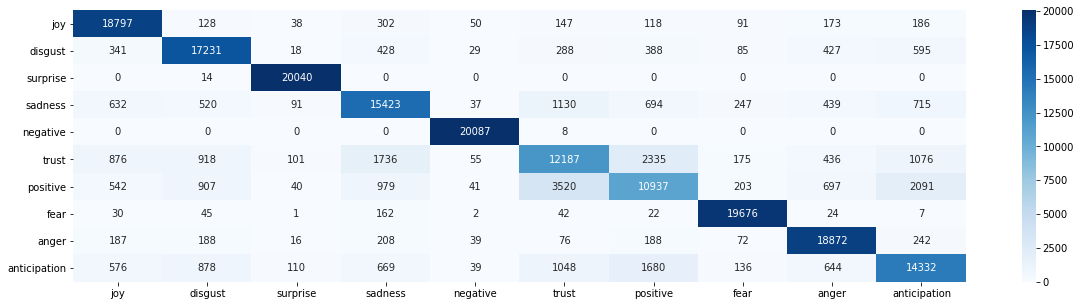

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20, 5))

sns.heatmap(cm, fmt="d", annot=True, cmap='Blues', xticklabels=list(set(y)), yticklabels=list(set(y)))